# tRNA-seq: simplified figs + introns 

## Version: transcript-level quantification with Salmon

Patrick suggested plotting tRNA with more simple representation. Also to compare expression of intron-containing genes to those without introns. From Patrick:

    I just write to follow up on the tRNASeq results. in the attached plot, it is a bit busy, and I wonder whether we can work out different types of representations to make it a bit easier to interpret the result. Can we quantify % of expression of each tRNA from neochromosome vs. from the WT loci? Can we also group them by anticodons? 

    For the intron containing tRNAs, can we specifically pull them out to take a look? IT will be the firm evidence that splicing is not essential for tRNA genes, and we can then try to KO SEN complex. 


**Samples**
- BY4741 + 128 kb neochromosome
- BY4741 + pRS415
- triple-syn + 128 kb neochromosome
- triple-syn + pRS415

I believe triple-syn is YZY175: MATalpha leu2∆0 lys2∆0 MET15 his3∆1 ura3∆0 synIII synSUP61::HO synVI SYN-WT.PRE4 IXL-synIXR 

Data comes from two tRNA sequencing runs by Daniel on 2016-08-19 and 2016-10-12. Two experiments differ slightly: in second experiment Daniel did more thorough removal of rRNAs.

**Here I use transcript-level quantification (Salmon) to estimate tRNA levels**

<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>

# IMPORTANT CAVEATS

## Please read before you continue...

It is difficult to quantify (pre)tRNA expression and determine from where in the genome they originate. Two factors make it difficult:

(1) tRNAs are hard to sequence because of modifications and stable secondary structures that inhibit reverse transcription
(2) pinpointing where in the genome pre-tRNAs originate is even more difficult because only a few nucleotides differentiate pre-tRNAs originating from different locations

A thermostable reverse transcriptase helped us overcome (1). If we were to use AlkB to remove modifications as in [Cozen et al. and Zheng et al.](http://www.nature.com/nmeth/journal/v12/n9/full/nmeth.3516.html) we could improve our results further. At the time we performed sequencing, we were unable to aquire AlkB for testing.

To tackle (2) I use a new RNA-seq quantification approach called "transcript-level quantification" with [Salmon](https://www.nature.com/nmeth/journal/v14/n4/abs/nmeth.4197.html). Basically reads are mapped directly to potential RNAs from which they might originate. Transcipt levels are then estimated using a dual-phase parallel inference algorithm (basically determining transcript quantifications that would make the observed data most likely). In the case of tRNAs, mapping is performed on a database that contains all tRNA species (and other ncRNAs), including both pre-tRNAs and mature tRNAs (tRNA database). Unlike alignment, transcript levels are "estimated" given the entirety of the dataset/reads. Since I always map to the same RNA database (independent of strain) there is a possibility for misquantification. You will see this in the analysis. For example, tRNAs on neochromosome have non-zero values in strain that doesn't contain the neochromosome. The effect is small but non-negligable. I believe this happens most often when there isn't enough data/differences among pre-tRNAs to distinguish expression from different tRNA species, e.g. not enough leader sequence present so reads obtained are conistent with expression from multiple loci.   

I have also performed a strict traditional alignment-based approach. Here I align to the tRNA database described above and only count reads that align uniquely. This throws away most of the reads (5-20% remaining). Some tRNA species aren't quantified at all. I think it also introduces a number of biases that distort the analysis. I do not think this approach is statistically sound. I do not show results from this analysis here. 

In [1]:
suppressMessages({
    .libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
    # config opts and libraries
    options(repr.plot.width = 6)
    options(repr.plot.height = 5)
    options(jupyter.plot_mimetypes = 'image/png')
    library(wasabi)
    library(sleuth)
    library(pheatmap)
    library(forcats)
    library(ggExtra)
    library(LSD)
    library(MASS)
    library(ggrepel)
    devtools::source_url("https://raw.githubusercontent.com/scalefreegan/R-tools/master/defaultRlibs.R")
    devtools::source_url("https://raw.githubusercontent.com/scalefreegan/steinmetz-lab/master/yeast2_0/scripts/seqtools.R")
})

In [2]:
suppressMessages({
    sample2ezname = function(x) {
        o = x
        o[x == "S1"] = "BY4741+neo"
        o[x == "S2"] = "BY4741"
        o[x == "S3"] = "triple-syn+neo"
        o[x == "S4"] = "triple-syn"
        return(o)
    }
    sample2reference = function(x) {
        o = x
        o[x == "BY4741+neo"] = "BY4741"
        o[x == "BY4741"] = "BY4741"
        o[x == "triple-syn+neo"] = "triple-syn"
        o[x == "triple-syn"] = "triple-syn"
        return(o)
    }
    chr2ezname = function(x) {
        o = x
        o[x == "chr17"] = "mito"
        o[x == "chr18"] = "neo"
        return(o)
    }
    RESULTS = "/g/steinmetz/project/IESY/trna/results/2016-10-12-HGWGFAFXX/salmon/combined"
    results = readRDS(file.path(RESULTS, "results.rds"))

    # Add tRNA intron annotations
    if (is.null(results$intron)) {
        # load tRNA intron annotations
        intron_trnas = read_tsv("/g/steinmetz/project/IESY/trna/data/trna_Gene_FeatureType_Introns.tsv")
        # convert chr names to arabic numbers
        intron_trnas$Gene.chromosomeLocation.locatedOn.primaryIdentifier = 
            roman2arabic(intron_trnas$Gene.chromosomeLocation.locatedOn.primaryIdentifier)
        intron_trnas$Isotype = sapply(intron_trnas$Gene.secondaryIdentifier, function(j) {
            gsub("[\\(\\)]", "", regmatches(j, gregexpr("\\(.*?\\)", j))[[1]])
                 })
        intron_trnas = mutate(intron_trnas, Isotype = gsub("U","T",Isotype))
        # add intron annotations to results table
        results$intron = apply(results, 1, function(i){
           # print(i)
            thisisotype = i[["Isotype"]]
            thischr = i[["seqid"]]
            subintrons = intron_trnas %>% 
                            filter(Isotype==thisisotype, 
                                     Gene.chromosomeLocation.locatedOn.primaryIdentifier==thischr)
            if (dim(subintrons)[1]>0) {
                ss = as.numeric(i[["start"]])
                ee = as.numeric(i[["end"]])
                subintrons = subintrons %>% 
                             mutate(sdist = abs(Gene.chromosomeLocation.start - ss),
                                edist = abs(Gene.chromosomeLocation.end - ee)) %>% 
                             arrange(sdist,edist)
                if (dim(subintrons)[1]==1) {
                    if (subintrons$sdist<20000 && subintrons$edist<20000) {
                        return(T)
                    } else {
                        return(F)
                    }
                } else {
                    #print("More than one on a chr. Taking first (closest match)")
                    subintrons = subintrons[1,]
                    if (subintrons$sdist<20000 && subintrons$edist<20000) {
                        return(T)
                    } else {
                        return(F)
                    }
                }
            } else {
                return(F)
            }
        })
    }
})

trnas = results %>% filter(grepl("tRNA",Name))
trnas$ezseqid[is.na(trnas$ezseqid)] = "Mature"

rerun = F
if (!file.exists(file.path(RESULTS,"pairresults.rds")) | rerun) {
    pairresults = filter(trnas,!is.na(pair)) %>% rowwise() %>% do({
        thisrow = .
        AA = thisrow$AA
        Isotype = thisrow$Isotype
        thissample = thisrow$sample
        thisreplicate = thisrow$replicate
        ezsample = thisrow$ezsample
        syn.Name = thisrow$Name
        syn.TPM = thisrow$TPM
        syn.NumReads = thisrow$NumReads
        pair = filter(results,Name==thisrow$pair,sample==thissample,replicate==thisreplicate)
        wt.Name = pair$Name
        wt.TPM = pair$TPM
        wt.NumReads = pair$NumReads
        intron = pair$intron
        syn.percent = syn.TPM/(syn.TPM+wt.TPM)
        wt.percent = wt.TPM/(syn.TPM+wt.TPM)
        reference = sample2reference(ezsample)
        o = data.frame(AA, Isotype, intron, ezsample, sample=thissample,
                       replicate=thisreplicate, syn.Name, syn.TPM, syn.NumReads,
                       wt.Name, wt.TPM, wt.NumReads,syn.percent,wt.percent,reference)
        return(o)
    })

    pairresults = pairresults %>% rowwise() %>% do({
        thisrow = .
        #print(thisrow)
        this.AA = thisrow$AA
        this.Isotype = thisrow$Isotype
        this.sample = thisrow$sample
        this.replicate = thisrow$replicate
        this.ezsample = thisrow$ezsample
        this.syn.Name = thisrow$syn.Name
        this.wt.Name = thisrow$wt.Nam
        this.intron = thisrow$intron
        this.syn.percent = thisrow$syn.percent
        this.wt.percent = thisrow$wt.percent
        this.reference = sample2reference(this.ezsample)
        refval = pairresults %>% filter(AA==this.AA,Isotype==this.Isotype,replicate==this.replicate,
                                   ezsample==this.reference,syn.Name==this.syn.Name,
                                    wt.Name==this.wt.Name)
        syn.percent.norm = this.syn.percent - refval$syn.percent
        syn.TPM = thisrow$syn.TPM
        wt.TPM = thisrow$wt.TPM
        syn.TPM.corr = thisrow$syn.TPM - refval$syn.TPM
        #print(refval)
        o = data.frame(AA=this.AA, Isotype=this.Isotype, intron=this.intron, 
                       ezsample=this.ezsample, sample=this.sample,
                       replicate=this.replicate, syn.Name=this.syn.Name, 
                       wt.Name=this.wt.Name, 
                       syn.percent=this.syn.percent,
                       syn.percent.norm,
                       reference=this.reference,
                       syn.TPM,
                       wt.TPM,
                       syn.TPM.corr
                      )
        return(o)
    })
    saveRDS(pairresults,file.path(RESULTS,"pairresults.rds"))
} else {
    pairresults = readRDS(file.path(RESULTS,"pairresults.rds"))
}

pairresults_summary = pairresults %>% ungroup() %>% group_by(AA, ezsample) %>% 
    summarise(intron = sum(intron), 
              syn.percent.norm.m=mean(syn.percent.norm,na.rm = T),
              syn.percent.norm.se=sd(syn.percent.norm,na.rm = T)/sqrt(n()),
              syn.percent.m=mean(syn.percent,na.rm = T),
              syn.percent.se=sd(syn.percent,na.rm = T)/sqrt(n()),
              n.pre.trna=n())

# Figure 1: Corrected percent expression from neochromosome relative to native genome

% expression from neochromosome = $ \frac{TPM^{i}_{neo}}{TPM^{i}_{neo}+TPM^{i}_{wt}} $

$TPM^{i}_{neo}$ = transcripts per million of pre-tRNA *i* on neochromosome

$TPM^{i}_{wt}$ = transcripts per million of pre-tRNA *i* on native chromosome

% expression is calculated individually for each neo/wt pair and separately for each biological replicate (x2)

To **correct** for misquantification I subtract % expression from neochromosome in strain without the neochromosome (e.g. BY4741) from strain with neochromosome (BY4741+neo). I think these are the most robust results.

Warning message:
: Removed 2 rows containing missing values (position_stack).Warning message:
: Removed 4 rows containing missing values (geom_errorbar).

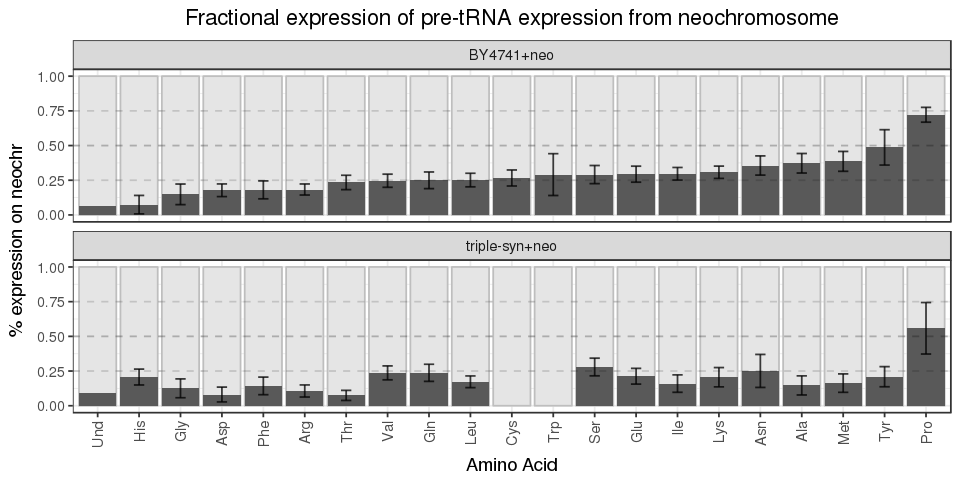

In [3]:
options(repr.plot.width = 8)
options(repr.plot.height = 4)
ref4order = filter(pairresults_summary,ezsample=="BY4741+neo")
aaorder = ref4order$AA[order(ref4order$syn.percent.norm.m,decreasing = F)]
p1 <- ggplot(filter(pairresults_summary,ezsample%in%c("BY4741+neo","triple-syn+neo"))) + 
    geom_bar(aes(x=factor(AA,levels=aaorder),y=1),stat="identity",fill="gray90",color="grey") +
    geom_bar(aes(x=factor(AA,levels=aaorder),y=syn.percent.norm.m),stat = "identity") +
    ylim(c(0,1)) + theme_bw() + ylab("% expression on neochr") + xlab("Amino Acid") +
    #geom_errorbar(limits, position = dodge, width = 0.25)
    geom_hline(yintercept=0.5,linetype=2,alpha=0.25) +  
    geom_hline(yintercept=0.25,linetype=2,alpha=0.15) + 
    geom_hline(yintercept=0.75,,linetype=2,alpha=0.15) +
    geom_errorbar(aes(x=AA,ymin=syn.percent.norm.m-syn.percent.norm.se,
                      ymax=syn.percent.norm.m+syn.percent.norm.se,width = 0.25),alpha=0.75) +
    facet_wrap(~ezsample, ncol = 1) + rotateTextX() +
    ggtitle("Fractional expression of pre-tRNA expression from neochromosome") + 
theme(plot.title = element_text(hjust = 0.5))
p1

Expression aggregated across two biological replicates and each pre-tRNA encoding each amino acid. Error bars are standard error.

Unclear why expression levels are different in triple-syn strain and why Cys/Trp drop out. 

# Figure 2: Fractional expression from neochromosome is not associated with whether pre-tRNA contains an intron or tRNA copy number

Warning message:
: Removed 2 rows containing missing values (position_stack).Warning message:
: Removed 4 rows containing missing values (geom_errorbar).

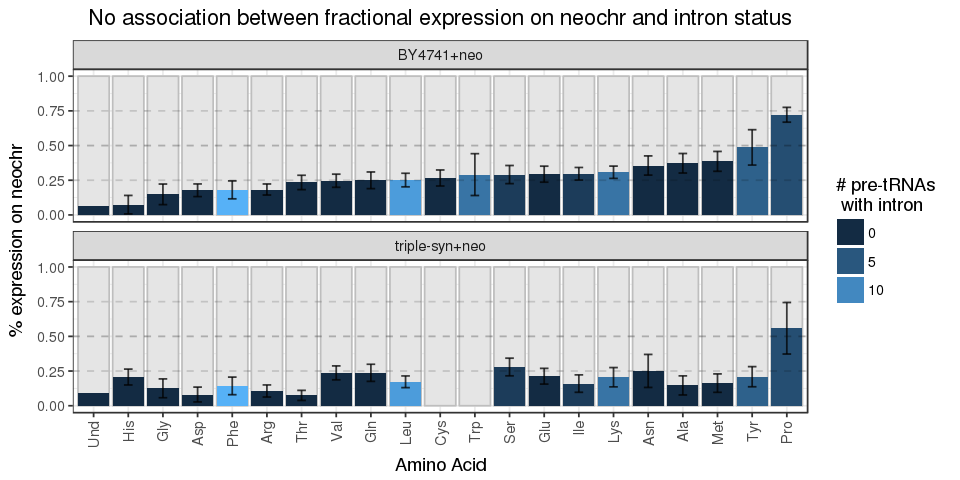

In [4]:
options(repr.plot.width = 8)
options(repr.plot.height = 4)
ref4order = filter(pairresults_summary,ezsample=="BY4741+neo")
aaorder = ref4order$AA[order(ref4order$syn.percent.norm.m,decreasing = F)]
p2.1 <- ggplot(filter(pairresults_summary,ezsample%in%c("BY4741+neo","triple-syn+neo"))) + 
    geom_bar(aes(x=factor(AA,levels=aaorder),y=1),stat="identity",fill="gray90",color="grey") +
    geom_bar(aes(x=factor(AA,levels=aaorder),y=syn.percent.norm.m, fill=intron),stat = "identity") +
    ylim(c(0,1)) + theme_bw() + ylab("% expression on neochr") + xlab("Amino Acid") +
    #geom_errorbar(limits, position = dodge, width = 0.25)
    geom_hline(yintercept=0.5,linetype=2,alpha=0.25) +  
    geom_hline(yintercept=0.25,linetype=2,alpha=0.15) + 
    geom_hline(yintercept=0.75,,linetype=2,alpha=0.15) +
    geom_errorbar(aes(x=AA,ymin=syn.percent.norm.m-syn.percent.norm.se,
                      ymax=syn.percent.norm.m+syn.percent.norm.se,width = 0.25),alpha=0.75) +
    facet_wrap(~ezsample, ncol = 1) + rotateTextX() +
    ggtitle("No association between fractional expression on neochr and intron status") + 
    theme(plot.title = element_text(hjust = 0.5)) +
    guides(fill=guide_legend(title="# pre-tRNAs\n with intron"))
p2.1

There is not an obvious correlation between whether a tRNA contains and intron and how it is expressed from the neochromosome.

Warning message:
: Removed 2 rows containing missing values (position_stack).Warning message:
: Removed 4 rows containing missing values (geom_errorbar).

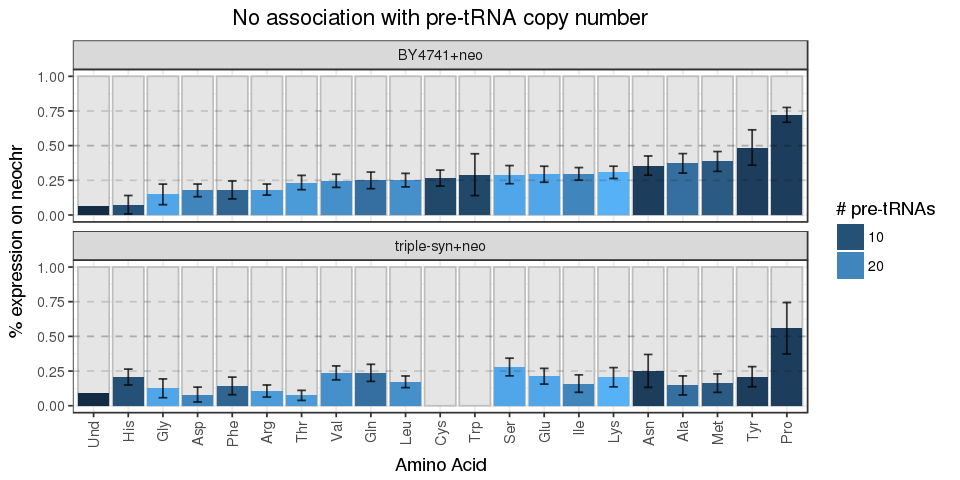

In [5]:
options(repr.plot.width = 8)
options(repr.plot.height = 4)
ref4order = filter(pairresults_summary,ezsample=="BY4741+neo")
aaorder = ref4order$AA[order(ref4order$syn.percent.norm.m,decreasing = F)]
p2.1 <- ggplot(filter(pairresults_summary,ezsample%in%c("BY4741+neo","triple-syn+neo"))) + 
    geom_bar(aes(x=factor(AA,levels=aaorder),y=1),stat="identity",fill="gray90",color="grey") +
    geom_bar(aes(x=factor(AA,levels=aaorder),y=syn.percent.norm.m, fill=n.pre.trna),stat = "identity") +
    ylim(c(0,1)) + theme_bw() + ylab("% expression on neochr") + xlab("Amino Acid") +
    #geom_errorbar(limits, position = dodge, width = 0.25)
    geom_hline(yintercept=0.5,linetype=2,alpha=0.25) +  
    geom_hline(yintercept=0.25,linetype=2,alpha=0.15) + 
    geom_hline(yintercept=0.75,,linetype=2,alpha=0.15) +
    geom_errorbar(aes(x=AA,ymin=syn.percent.norm.m-syn.percent.norm.se,
                      ymax=syn.percent.norm.m+syn.percent.norm.se,width = 0.25),alpha=0.75) +
    facet_wrap(~ezsample, ncol = 1) + rotateTextX() +
    ggtitle("No association with pre-tRNA copy number") + 
    theme(plot.title = element_text(hjust = 0.5)) + 
    guides(fill=guide_legend(title="# pre-tRNAs"))
p2.1

Similarly, pre-tRNA copy number (number of tRNAs encoding an amino acid) does not have an obvious correlation with expression from neochromosome. 

# Figure 3: Motivation for correction

Before moving onto a more detailed characterization, it's important to understand my motivation for correcting the data. As I mentioned above, Salmon does produce misquantifications. This is because I always quantify with respect to the same tRNA database. 

Misquantifications can be observed in the left side panels below. Strains without the neochromosome (BY4741 ad triple-syn). should have 0 quantification for tRNAs on the neochromosome. That's clearly not the case. It's interesting to observe that the amount of misquantification appears to be similar across strains aggrergated at the level of amino acid, i.e. misquantification profile of BY4741 is very similar to triple-syn. This suggests that there is some reproducibility to the misquantification. This is not so hard to imagine, especially if one considers that tRNA species vary in the "identifiability", i.e. the extent to which they contain sequences that uniquely identify individual copies.   

Thus I prefer to subtract out the misquantification. Currently I do this independently for each sample. In the future I could imagine a generalized "misquantification profile" that could be subtracted from all samples. 

The resulting panel "After correction" is the same as Figure 1.

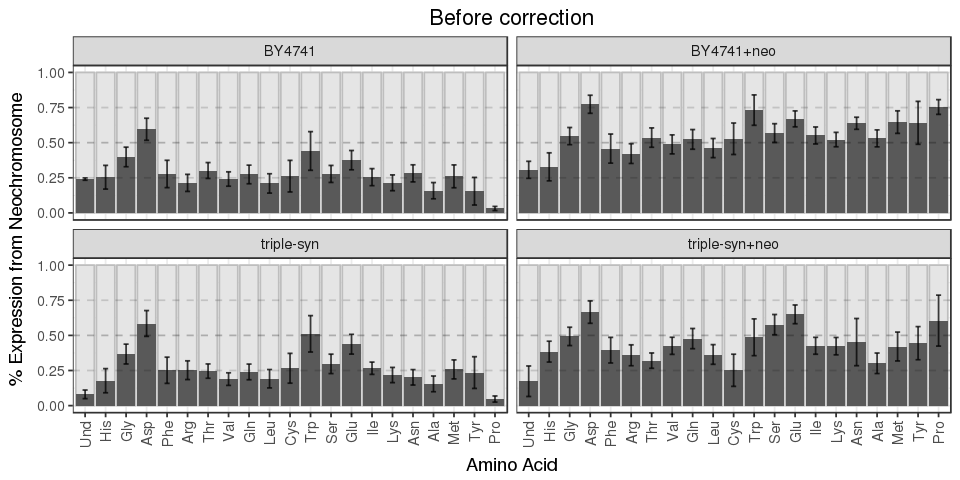

In [6]:
options(repr.plot.width = 8)
options(repr.plot.height = 4)
p3.1 <- ggplot(filter(pairresults_summary)) + 
    geom_bar(aes(x=factor(AA,levels=aaorder),y=1),stat="identity",fill="gray90",color="grey") +
    geom_bar(aes(x=factor(AA,levels=aaorder),y=syn.percent.m),stat = "identity") +
    ylim(c(0,1)) + theme_bw() + ylab("% Expression from Neochromosome") + xlab("Amino Acid") +
    #geom_errorbar(limits, position = dodge, width = 0.25)
    geom_hline(yintercept=0.5,linetype=2,alpha=0.25) +  
    geom_hline(yintercept=0.25,linetype=2,alpha=0.15) + 
    geom_hline(yintercept=0.75,,linetype=2,alpha=0.15) +
    geom_errorbar(aes(x=AA,ymin=syn.percent.m-syn.percent.se,
                      ymax=syn.percent.m+syn.percent.se,width = 0.25),alpha=0.75) +
    facet_wrap(~ezsample) + rotateTextX() + ggtitle("Before correction") + 
    theme(plot.title = element_text(hjust = 0.5))
p3.1

Warning message:
: Removed 2 rows containing missing values (position_stack).Warning message:
: Removed 4 rows containing missing values (geom_errorbar).

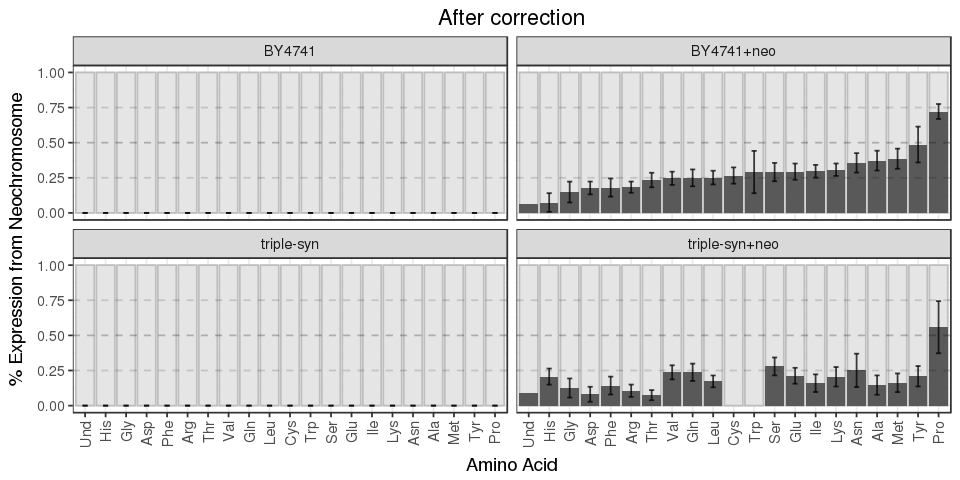

In [7]:
options(repr.plot.width = 8)
options(repr.plot.height = 4)
p3.2 <- ggplot(filter(pairresults_summary)) + 
    geom_bar(aes(x=factor(AA,levels=aaorder),y=1),stat="identity",fill="gray90",color="grey") +
    geom_bar(aes(x=factor(AA,levels=aaorder),y=syn.percent.norm.m),stat = "identity") +
    ylim(c(0,1)) + theme_bw() + ylab("% Expression from Neochromosome") + xlab("Amino Acid") +
    #geom_errorbar(limits, position = dodge, width = 0.25)
    geom_hline(yintercept=0.5,linetype=2,alpha=0.25) +  
    geom_hline(yintercept=0.25,linetype=2,alpha=0.15) + 
    geom_hline(yintercept=0.75,,linetype=2,alpha=0.15) +
    geom_errorbar(aes(x=AA,ymin=syn.percent.norm.m-syn.percent.norm.se,
                      ymax=syn.percent.norm.m+syn.percent.norm.se,width = 0.25),alpha=0.75) +
    facet_wrap(~ezsample) + rotateTextX() + ggtitle("After correction") + 
    theme(plot.title = element_text(hjust = 0.5))
p3.2

# Reducing granularity

The take home from my analysis to date: 

- **at bulk level, tRNA pools appear to be highly buffered**

- **expresion of individual tRNA copies, however, would seem to be variable**

So -- as a whole or at the level of isotype, tRNA expression is largely stable. At the level of mature tRNAs, for example, there is not a significant difference in tRNA expression between any of the strains (+/- neochr or WT/triple-syn). However, at a more fine-graned level this breaks down. The precise correlation between individual tRNA species, for example, seems to be different depending on e.g. the location (neochromosome or genome). 

# Figure 4: pre-tRNA expression by chromosome

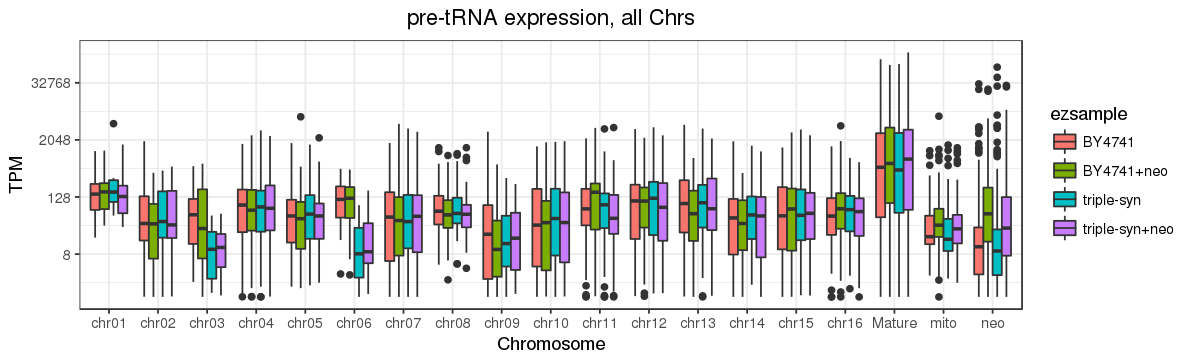

In [8]:
options(repr.plot.width = 10)
options(repr.plot.height = 3)
p4 <- ggplot(trnas) +
    geom_boxplot(aes(ezseqid, TPM + 1, fill = ezsample)) + scale_y_continuous(trans="log2") +
    ggtitle("pre-tRNA expression, all Chrs") + ylab("TPM") + xlab("Chromosome") +
    theme_bw() + theme(plot.title = element_text(hjust = 0.5))
p4

chr03, chr06 and the neochr are where we expect to see that largest changes.

# Figure 5: pre-tRNA expression on chr 3, 6 and neo only


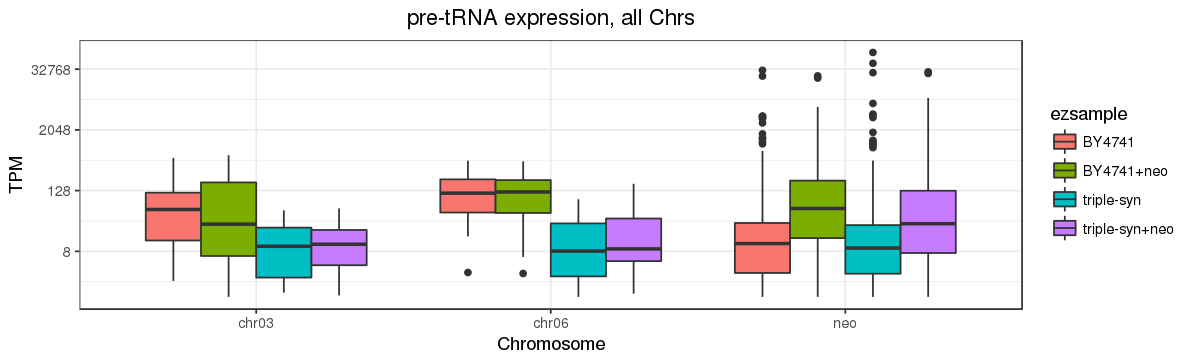

In [9]:
p5 <- ggplot(results %>% filter(grepl("tRNA",Name),ezseqid %in% c("chr03","chr06","neo"))) +
    geom_boxplot(aes(ezseqid, TPM + 1, fill = ezsample)) + scale_y_continuous(trans="log2") +
    ggtitle("pre-tRNA expression, all Chrs") + ylab("TPM") + xlab("Chromosome") +
    theme_bw() + theme(plot.title = element_text(hjust = 0.5))
p5

Here we can clearly see patterns of tRNA expression we would expect. In strains lacking neo-chromosome, there is very little expression attributed to tRNAs on neochromsome (median = ~8 transcripts per million, TPM). This is 8-fold higher in strains with neochromosome (median = ~>64 TPM). Similarly there is very little expression from chr03 and chr06 in triple-syn strain (since tRNAs have been removed from these chromosomes). Background misquantification (median = ~8 transcripts per million) is clear here.

# Figure 6: Median pre-tRNA expression from neochromosome compared to genome grouped by amino acid and anticodon

Each tRNA isotype and anticodon represent as a individual point. Again show values before and after correction (normalization wrt "negative" control = -neochromosome)

Warning message:
: Removed 20 rows containing missing values (geom_point).

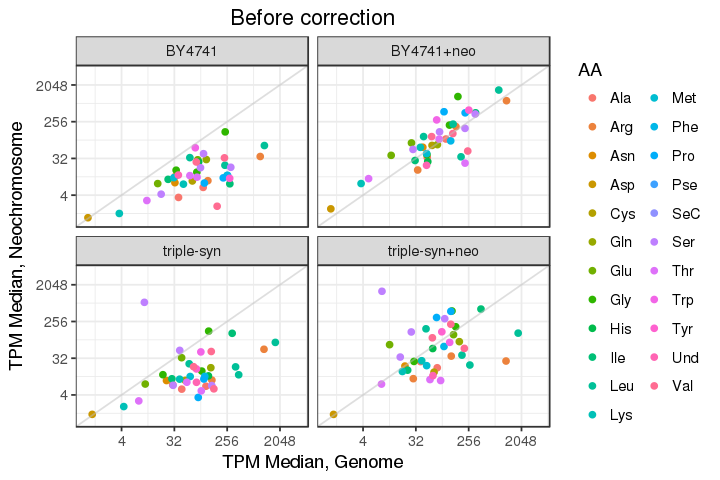

In [10]:
options(repr.plot.width = 6)
options(repr.plot.height = 4)
synVwt =  results %>% 
        group_by(AA, Isotype, ezsample, origin) %>% 
        dplyr::summarize(median(TPM), median(NumReads), intron = sum(intron)) %>%
        filter(Isotype != "NA", Isotype != "", origin != "NA") %>% 
        group_by(AA,Isotype) %>% 
        mutate(intron = max(intron)>0)
synVwt_wide = dcast(synVwt, formula = AA + Isotype + ezsample + intron ~ origin,
                    value.var = "median(TPM)")
p6 <- ggplot(synVwt_wide) + geom_point(aes(x=WT+1,y=SYN+1,color=AA)) + 
    scale_y_continuous(trans="log2",limits = c(1,2^12)) + 
    scale_x_continuous(trans="log2",limits = c(1,2^12)) +
    facet_wrap(~ezsample) + ylab("TPM Median, Neochromosome") +
    xlab("TPM Median, Genome") + ggtitle("Before correction") +
    theme_bw() + theme(plot.title = element_text(hjust = 0.5)) +
    geom_abline(intercept = 0, color="grey",alpha=0.5)
p6

In [11]:
# correct for "misquantification"
suppressWarnings({altresults = results %>% filter(origin!="NA") %>% rowwise() %>% do({
    thisrow = .
    if (thisrow$origin == "SYN") {
        # needs to be corrected
        correctionSample = ifelse(thisrow$sample %in% c("S1","S2"),"S2","S4")
        correctionRow = results %>% filter(Name == thisrow$Name, 
                                   sample == correctionSample, replicate == thisrow$replicate)
        thisrow$TPM = thisrow$TPM - correctionRow$TPM
        thisrow$NumReads = thisrow$NumReads - correctionRow$NumReads
        if (thisrow$TPM < 1) {
           thisrow$TPM = 0 
        }
        if (thisrow$NumReads < 1) {
           thisrow$NumReads = 0 
        }
        return(data.frame(thisrow))
    } else {
        return(data.frame(thisrow))
    }
})})
synVwt_alt = altresults %>% ungroup() %>%
      group_by(AA,Isotype,ezsample,origin) %>% dplyr::summarize(median(TPM),median(NumReads),intron=sum(intron)) %>%
      filter(Isotype!="NA",Isotype!="",origin!="NA") %>% group_by(AA,Isotype) %>% mutate(intron = max(intron)>0)
synVwt_wide_alt = dcast(synVwt_alt,formula = AA+Isotype+ezsample+intron ~ origin,value.var = "median(TPM)")

Warning message:
: Removed 20 rows containing missing values (geom_point).

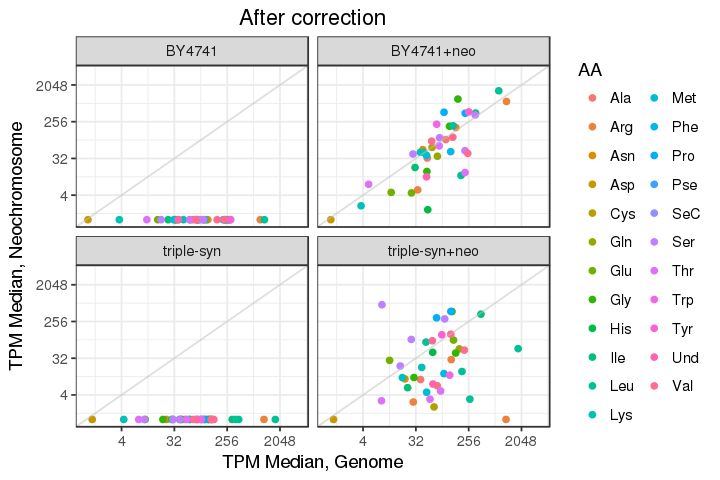

In [12]:
p7 <- ggplot(synVwt_wide_alt) + geom_point(aes(x=WT+1,y=SYN+1,color=AA)) + 
    scale_y_continuous(trans="log2",limits = c(1,2^12)) + 
    scale_x_continuous(trans="log2",limits = c(1,2^12)) +
    geom_abline(intercept = 0, color="grey",alpha=0.5) +
    facet_wrap(~ezsample) + ylab("TPM Median, Neochromosome") +
    xlab("TPM Median, Genome") + ggtitle("After correction") +
    theme_bw() + theme(plot.title = element_text(hjust = 0.5))
p7

# Figure 8: Intron status is not associated with expression on neochromosome

Data suggests that tRNA isotypes containing introns are expressed indisintguishably on neochromosome.

Warning message:
: Removed 20 rows containing missing values (geom_point).

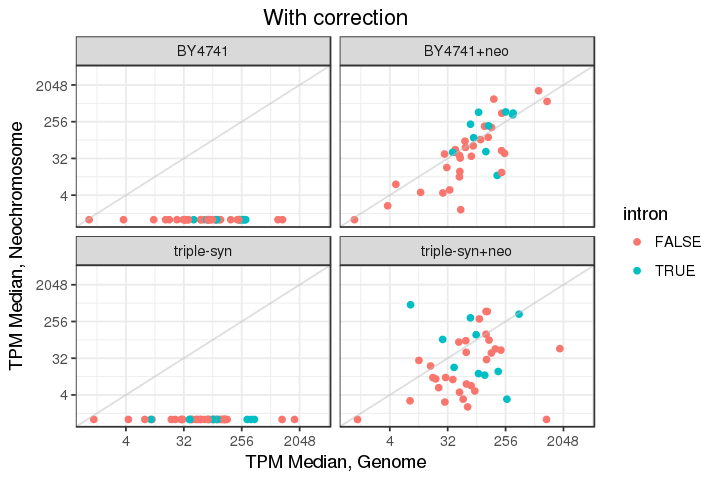

In [13]:
options(repr.plot.width = 6)
options(repr.plot.height = 4)
p8 <- ggplot(synVwt_wide_alt) + geom_point(aes(x=WT+1,y=SYN+1,color=intron)) + 
    scale_y_continuous(trans="log2",limits = c(1,2^12)) + 
    scale_x_continuous(trans="log2",limits = c(1,2^12)) +
    facet_wrap(~ezsample) + ylab("TPM Median, Neochromosome") +
    xlab("TPM Median, Genome") + ggtitle("With correction") +
    theme_bw() + theme(plot.title = element_text(hjust = 0.5)) +
    geom_abline(intercept = 0, color="grey",alpha=0.5)
p8

# Figure 9: Paired tRNA gene expression: Genome v. Neochromosome

And here's where things get interesting. Despite the agreement between tRNA expression levels at aggregate levels, at the level of individual pairs of tRNAs (i.e. neochromsome encoded copy compared to its cognate on the chromosome), correlation breaks down a little bit. There is not strict 1:1 correspondence between expression from the genome and on the neochromsome (although they are correlated). It would seem that, despite differences at the level of individual tRNA species, overall tRNA expression across all isotypes encoded for a parituclar amino acid is stablized. Should also be noted that individual tRNA expression levels across biologival replicates are largely reproducible (see Figure 11 below).

Warning message:
: Removed 18 rows containing missing values (geom_point).

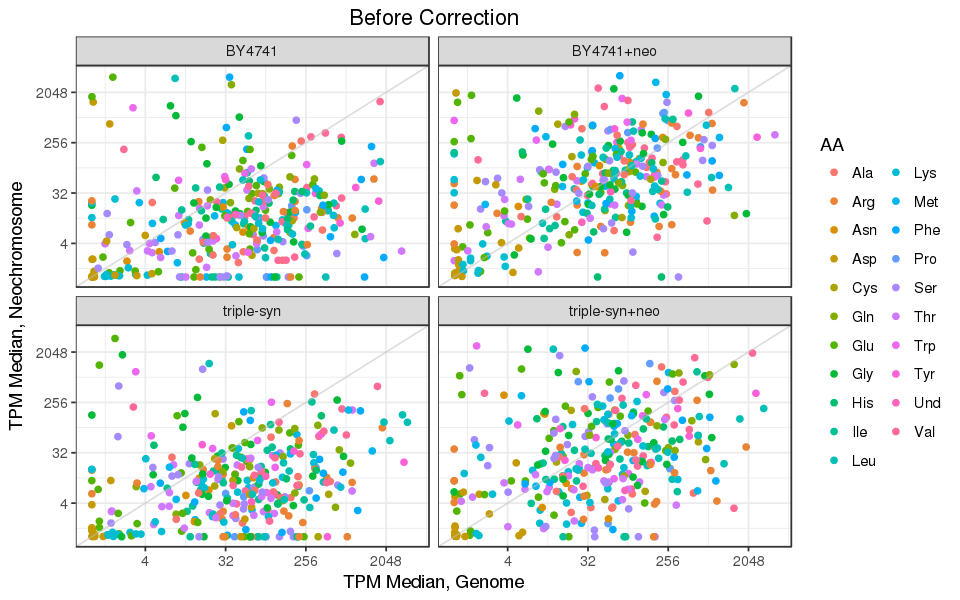

In [14]:
options(repr.plot.width = 8)
options(repr.plot.height = 5)
p9 <- ggplot(data = pairresults) + geom_point(aes(x=wt.TPM+1,y=syn.TPM+1,color=AA)) +
    scale_y_continuous(trans="log2",limits = c(1,2^12)) + 
    scale_x_continuous(trans="log2",limits = c(1,2^12)) +
    facet_wrap(~ezsample) + ylab("TPM Median, Neochromosome") +
    xlab("TPM Median, Genome") +
    geom_abline(intercept = 0, color="grey",alpha=0.5) +
    theme_bw() + theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle("Before Correction")
p9

Warning message:
In self$trans$transform(x): NaNs producedWarning message:
: Transformation introduced infinite values in continuous y-axisWarning message:
: Removed 125 rows containing missing values (geom_point).

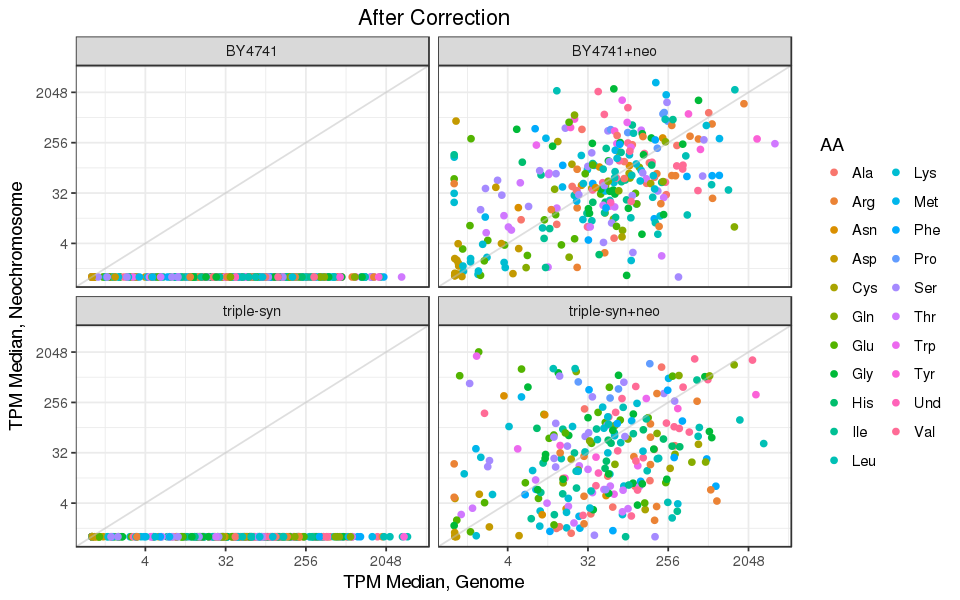

In [15]:
options(repr.plot.width = 8)
options(repr.plot.height = 5)
p9.2 <- ggplot(data = pairresults) + geom_point(aes(x=wt.TPM+1,y=syn.TPM.corr+1,color=AA)) +
    scale_y_continuous(trans="log2",limits = c(1,2^12)) + 
    scale_x_continuous(trans="log2",limits = c(1,2^12)) +
    facet_wrap(~ezsample) + ylab("TPM Median, Neochromosome") +
    xlab("TPM Median, Genome") +
    geom_abline(intercept = 0, color="grey",alpha=0.5) +
    theme_bw() + theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle("After Correction")
p9.2

# Figure 10: Intron status is not associated with differences in expression at the level of individual tRNA pairs

Similar to observations above. No clear difference between expression of tRNAs that contain or do not contain an intron.

Warning message:
In self$trans$transform(x): NaNs producedWarning message:
: Transformation introduced infinite values in continuous y-axisWarning message:
: Removed 125 rows containing missing values (geom_point).

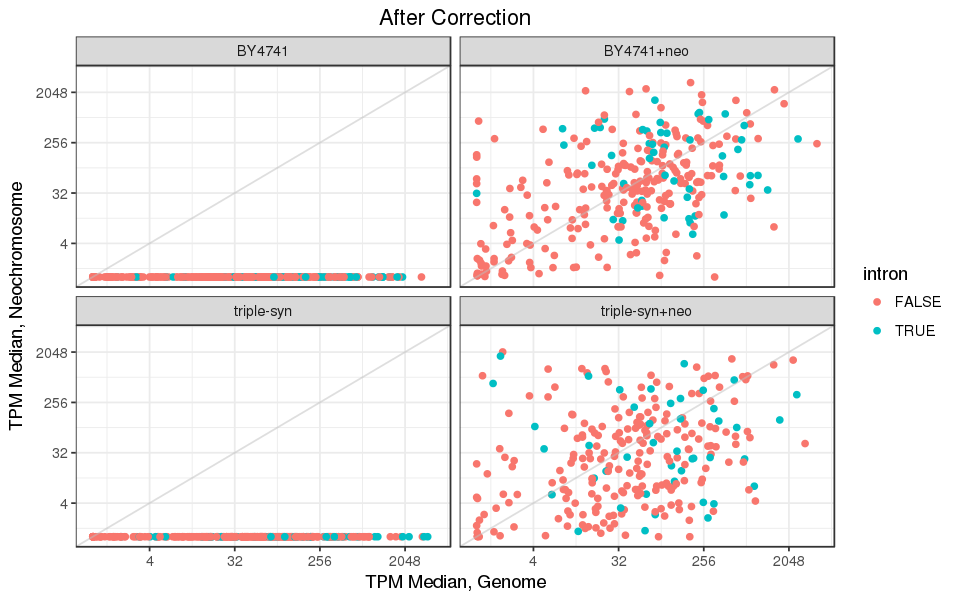

In [16]:
options(repr.plot.width = 8)
options(repr.plot.height = 5)
p10 <- ggplot(data = pairresults) + geom_point(aes(x=wt.TPM+1,y=syn.TPM.corr+1,color=intron)) +
    scale_y_continuous(trans="log2",limits = c(1,2^12)) + 
    scale_x_continuous(trans="log2",limits = c(1,2^12)) +
    facet_wrap(~ezsample) + ylab("TPM Median, Neochromosome") +
    xlab("TPM Median, Genome") +
    geom_abline(intercept = 0, color="grey",alpha=0.5) +
    theme_bw() + theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle("After Correction")
p10

# Figure 11: Expression of individual tRNA levels are reproducible across biological replicates

The correlation is a lower than we would normally expect from our sequencing data, but this may be result of the fact that the two replicates were processes differently (second batch had more stringent removal of rRNAs with RiboMinus).

Adding missing grouping variables: `Name.original`


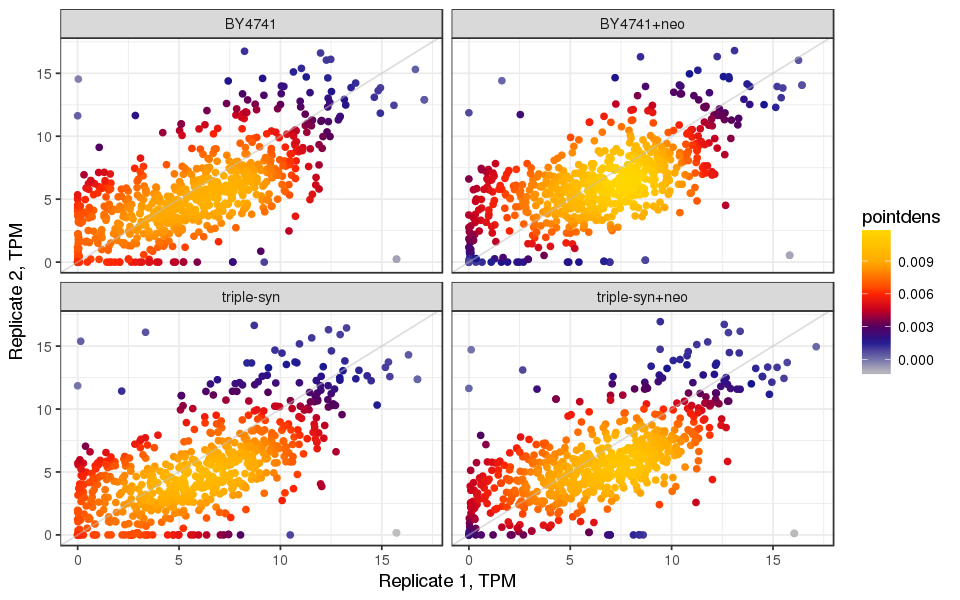

In [17]:
replicates = ungroup(results) %>% group_by(Name.original, ezsample) %>% 
    dplyr::select(Name, AA, ezsample, Isotype, intron, replicate, TPM) %>%
    spread(key = replicate,value = TPM) %>% mutate(x = log2(`1`+1), y = log2(`2`+1)) %>% 
    ungroup() %>% group_by(ezsample) %>%
    do({
        # Calculate 2d density over a grid
        # dens <- kde2d(x,y)
        thisdf = .
        dens <- kde2d(.$x,.$y)
        # create a new data frame of that 2d density grid
        gr <- data.frame(with(dens, expand.grid(dens$x,dens$y)), as.vector(dens$z))
        names(gr) <- c("xgr", "ygr", "zgr")
        # Fit a model
        mod <- loess(zgr~xgr*ygr, data=gr)
        # Apply the model to the original data to estimate density at that point
        # DF$pointdens <- predict(mod, newdata=data.frame(xgr=x, ygr=y))
        thisdf = mutate(thisdf,pointdens = predict(mod, 
                                newdata=data.frame(xgr=.$x, ygr=.$y)))
        return(thisdf)
    })

lm_eqn <- function(x, y, intercept = F){
    if (intercept) {
        m <- lm(y ~ x)
        eq <- substitute(italic(y) == a + b %.% italic(x)*","~~italic(r)^2~"="~r2, 
             list(a = format(coef(m)[1], digits = 2), 
                  b = format(coef(m)[2], digits = 2), 
                 r2 = format(summary(m)$r.squared, digits = 3)))
    } else {
        m <- lm(y ~ 0+ x)
        eq <- substitute(italic(y) == a %.% italic(x)*","~~italic(r)^2~"="~r2, 
             list(a = format(coef(m)[1], digits = 2),  
                 r2 = format(summary(m)$r.squared, digits = 3)))
    }
   return(as.character(as.expression(eq)))   
}
options(repr.plot.width = 8)
options(repr.plot.height = 5)
p11 <- ggplot() + geom_point(data = replicates, aes(x=x,y=y, color=pointdens)) + 
    #geom_smooth(data = replicates, aes(x=x,y=y), method = "lm", se = FALSE, color = "black") +
    #geom_text(data = replicates, x = 0, y = 2.8, label = lm_eqn(replicates$x, replicates$y), parse = TRUE, size = 6) + 
    scale_colour_gradientn(colours = LSD::colorpalette("heat",10)) + 
    #scale_fill_gradientn(colours = LSD::colorpalette("heat",5)) +
    #scale_y_continuous(trans="log2",limits = c(.1,2^12)) + 
    #scale_x_continuous(trans="log2",limits = c(.1,2^12)) +
    geom_abline(intercept = 0, color="grey",alpha=0.5) +
    facet_wrap(~ezsample) +
    theme_bw() +
    xlab("Replicate 1, TPM") +
    ylab("Replicate 2, TPM")
p11

## Correlation across data sets

In [18]:
replicates %>% ungroup() %>% group_by(ezsample) %>% dplyr::summarise(cor = cor(x,y))

,ezsample,cor
1,BY4741,0.666141
2,BY4741+neo,0.6396345
3,triple-syn,0.6360732
4,triple-syn+neo,0.6570721


# Figure 12: Replicate correlation grouped by amino acid

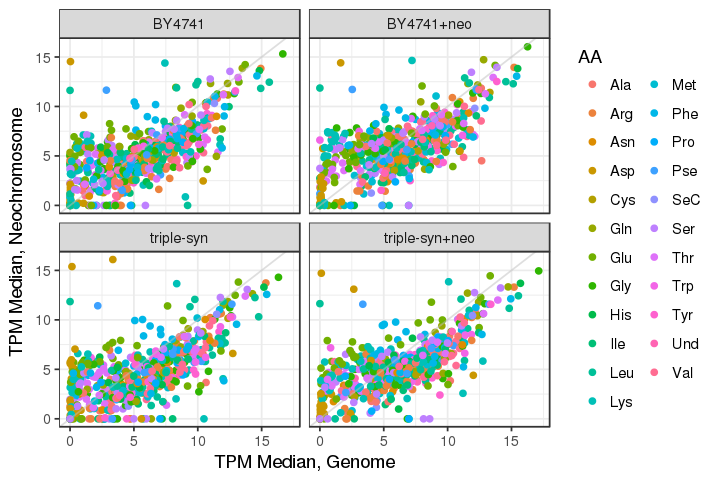

In [19]:
options(repr.plot.width = 6)
options(repr.plot.height = 4)
p11 <- ggplot(replicates %>% filter(grepl("tRNA",Name))) + 
        geom_point(aes(x=x,y=y,color=AA)) + 
        #scale_y_continuous(trans="log2") + 
        #scale_x_continuous(trans="log2") +
        facet_wrap(~ezsample) + ylab("TPM Median, Neochromosome") +
        xlab("TPM Median, Genome") +
        theme_bw() +
        geom_abline(intercept = 0, color="grey",alpha=0.5)
p11

# Extras

# tRNA expression by chromosome and amino acid

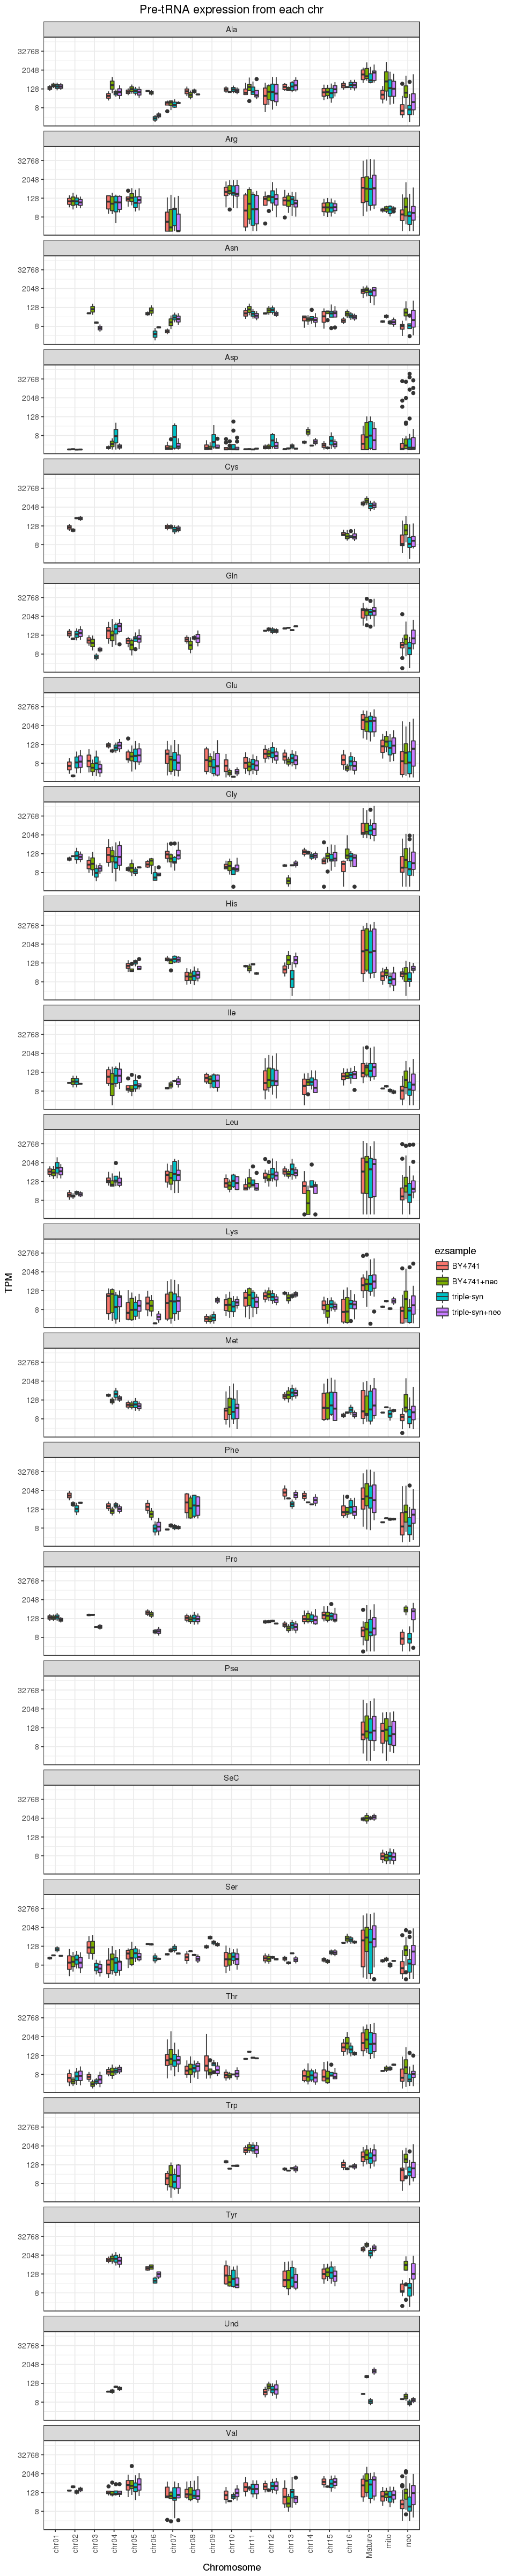

In [20]:
options(repr.plot.width = 8)
options(repr.plot.height = 40)
p13 <- ggplot(trnas) +
    geom_boxplot(aes(ezseqid, TPM + 1, fill = ezsample)) + scale_y_continuous(trans="log2") +
    ylab("TPM") + xlab("Chromosome") + 
    facet_wrap(~AA, ncol = 1) + ggtitle("Pre-tRNA expression from each chr") +
    theme_bw() + theme(plot.title = element_text(hjust = 0.5)) + rotateTextX()
p13